# Running Qiskit Aer with GPU and cuQuantum

This document introduces how to run Qiskit Aer with GPU and NVIDIA's cuQuantum API.
Qiskit Aer supports cuStateVec APIs in cuQuantum that accelerate statevector simulator.

Here is a simple example to simulate Quantum Volume circuit from Qiskit's circuit library. You can change number of qubits, depth and shots to be simulated. 

In [4]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import *

sim = AerSimulator(method='statevector', device='GPU')

qubits = 15
depth=10
shots = 10

circuit = QuantumVolume(qubits, depth, seed=0)
circuit.measure_all()
result = execute(circuit,sim,shots=shots,seed_simulator=12345).result()

print("{0} qubits Quantum Volume, Simulation Time = {1} sec".format(qubits,result.to_dict()['results'][0]['time_taken']))
counts = result.get_counts()
print(counts)

15 qubits Quantum Volume, Simulation Time = 0.004826054 sec
{'011010000111101': 1, '100101001000001': 1, '101100010110011': 1, '011110101110001': 1, '000001110000100': 1, '001101110000100': 1, '101100010101010': 1, '010111001000001': 1, '100100010100111': 1, '001101110011000': 1}


The example above does not use cuStateVec but calculated by using default GPU backend of Qiskit Aer.

To eanble cuStateVec, runtime option cuStateVec_enable should be set to True.

In [6]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import *

sim = AerSimulator(method='statevector', device='GPU', cuStateVec_enable=True)

qubits = 15
depth=10
shots = 10

circuit = QuantumVolume(qubits, depth, seed=0)
circuit.measure_all()

result = execute(circuit,sim,shots=shots,seed_simulator=12345).result()

if result.to_dict()['results'][0]['metadata']['cuStateVec_enable'] == True:
    print("cuStateVector is used for the simulation")
print("{0} qubits, Time = {1} sec".format(qubits,result.to_dict()['results'][0]['time_taken']))
counts = result.get_counts()
print(counts)


cuStateVector is used for the simulation
15 qubits, Time = 0.007037462 sec
{'011010000111101': 1, '100101001000001': 1, '101100010110011': 1, '011110101110001': 1, '000001110000100': 1, '001101110000100': 1, '101100010101010': 1, '010111001000001': 1, '100100010100111': 1, '001101110011000': 1}


Now let's compare the performance. Following benchmark measures simulation time of Quantum Volume for range of qubits.

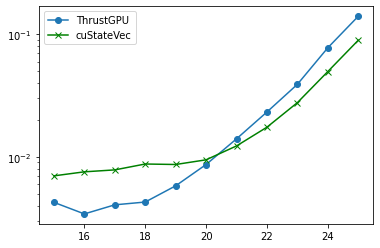

In [8]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import *
import matplotlib.pyplot as plt

sim = AerSimulator(method='statevector', device='GPU')

shots = 100
depth=10

time_thrust= []
time_cuStateVec= []
qubits_list = []

for qubits in range (15, 26):
    qubits_list.append(qubits)
    circuit = QuantumVolume(qubits, depth, seed=0)
    circuit.measure_all()

    result = execute(circuit,sim,shots=shots,seed_simulator=12345,fusion_threshold=20,cuStateVec_enable=False).result()
    time_thrust.append(float(result.to_dict()['results'][0]['time_taken']))

    result_cuStateVec = execute(circuit,sim,shots=shots,seed_simulator=12345,fusion_threshold=20,cuStateVec_enable=True).result()
    time_cuStateVec.append(float(result_cuStateVec.to_dict()['results'][0]['time_taken']))

plt.yscale("log")
plt.plot(qubits_list, time_thrust, marker="o", label='ThrustGPU')
plt.plot(qubits_list, time_cuStateVec, 'g', marker="x", label='cuStateVec')
plt.legend()


As you can see, cuStateVec is faster for higher number of qubits. This will be improved in the future release of cuQuantum and will be faster for lower number of qubits too. Before the improved release, please switch enabling/disabling cuStateVec by using cuStateVec_enable option suitable for your actual simulations.